<a href="https://colab.research.google.com/github/Saptar001/Tweet-Emotion-Recognition/blob/main/Tweet_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)


---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

     |████████████████████████████████| 1.7 MB 4.0 MB/s 
     |████████████████████████████████| 243 kB 50.3 MB/s 


In [4]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.5.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [5]:
dataset = nlp.load_dataset("emotion")

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [6]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [7]:
train = dataset["train"]
val = dataset["validation"]
test = dataset["test"]

In [8]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]

  return tweets, labels


In [9]:
tweets , labels = get_tweet(train)

In [11]:
tweets[1], labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [14]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [17]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

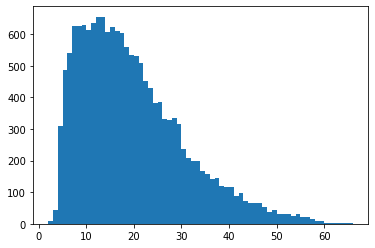

In [18]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [23]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences



In [24]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post',padding='post',maxlen=maxlen)

  return padded
  

In [25]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [28]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [29]:
classes = set(labels)
print(classes)

{'sadness', 'surprise', 'love', 'fear', 'anger', 'joy'}


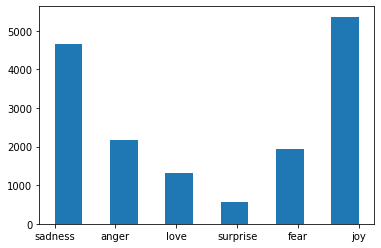

In [35]:
plt.hist(labels,bins=11)
plt.show()

In [41]:
class_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_class = dict((v,k) for k,v in class_to_index.items())

In [43]:
class_to_index

{'anger': 4, 'fear': 3, 'joy': 5, 'love': 2, 'sadness': 0, 'surprise': 1}

In [44]:
index_to_class

{0: 'sadness', 1: 'surprise', 2: 'love', 3: 'fear', 4: 'anger', 5: 'joy'}

In [45]:
name_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [51]:
train_labels = name_to_ids(labels)
print(labels[3],train_labels[3])

love 2


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [52]:
model = tf.keras.models.Sequential([
                                    
        tf.keras.layers.Embedding(10000, 16 , input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [56]:
val_tweets,val_labels = get_tweet(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = name_to_ids(val_labels)

In [57]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [58]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data = (val_sequences, val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 40s 60ms/step - loss: 1.2767 - accuracy: 0.5037 - val_loss: 0.8356 - val_accuracy: 0.6985
Epoch 2/20
500/500 [==============================] - 28s 57ms/step - loss: 0.5831 - accuracy: 0.7907 - val_loss: 0.5685 - val_accuracy: 0.8065
Epoch 3/20
500/500 [==============================] - 28s 57ms/step - loss: 0.3552 - accuracy: 0.8826 - val_loss: 0.4968 - val_accuracy: 0.8420
Epoch 4/20
500/500 [==============================] - 28s 57ms/step - loss: 0.2448 - accuracy: 0.9200 - val_loss: 0.4648 - val_accuracy: 0.8650
Epoch 5/20
500/500 [==============================] - 29s 57ms/step - loss: 0.1757 - accuracy: 0.9454 - val_loss: 0.3863 - val_accuracy: 0.8795
Epoch 6/20
500/500 [==============================] - 28s 57ms/step - loss: 0.1331 - accuracy: 0.9569 - val_loss: 0.3876 - val_accuracy: 0.8885
Epoch 7/20
500/500 [==============================] - 28s 57ms/step - loss: 0.0975 - accuracy: 0.9702 - val_loss: 0.4462 - val_accuracy:

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

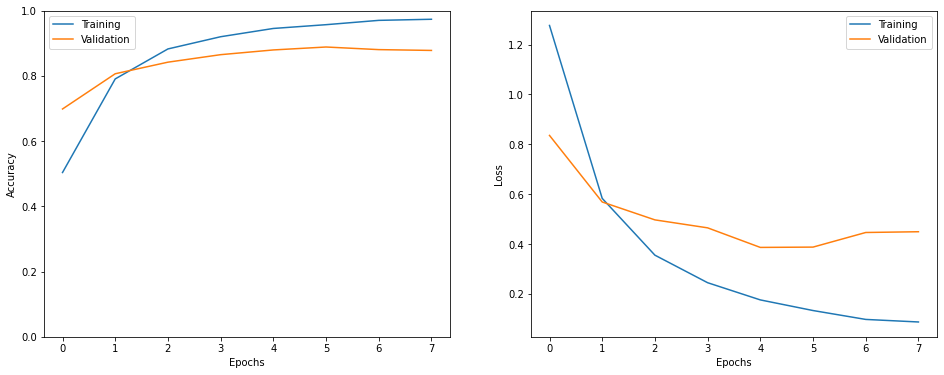

In [59]:
show_history(h)

In [60]:
test_tweets,test_labels = get_tweet(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = name_to_ids(test_labels)

In [61]:
_ = model.evaluate(test_sequences, test_labels)

63/63 [==============================] - 1s 20ms/step - loss: 0.4764 - accuracy: 0.8665


In [62]:
i = random.randint(0,len(test_labels)-1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_sequences[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Class:', pred_class)

Sentence: i feel welcomed into the barn like a son coming home
Emotion: joy
Predicted Class: joy


In [65]:
preds = model.predict_classes(test_sequences)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


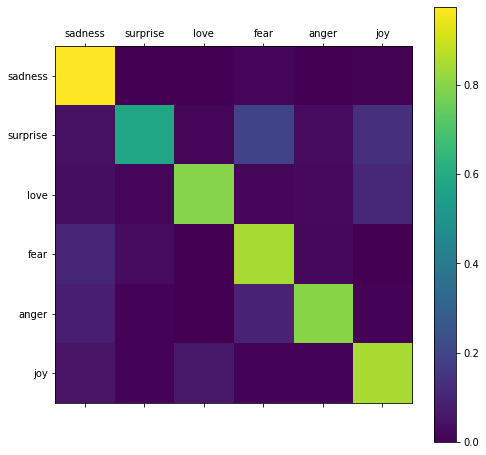

In [66]:
show_confusion_matrix(test_labels,preds, list(classes))